In [ ]:
!pip install sentence-transformers datasets numpy pandas scikit-learn matplotlib


In [ ]:
import time
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
# Load real benchmark dataset
dataset = load_dataset("stsb_multi_mt", "en")

test_data = dataset["test"]

# Take 200 samples for faster execution
sentence_pairs = []
gold_scores = []

for item in test_data.select(range(200)):
    sentence_pairs.append((item["sentence1"], item["sentence2"]))
    gold_scores.append(item["similarity_score"])


README.md: 0.00B [00:00, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/470k [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

en/dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
# Select Pretrained models
models = {
 "all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
 "all-mpnet-base-v2": "sentence-transformers/all-mpnet-base-v2",
 "paraphrase-MiniLM-L6-v2": "sentence-transformers/paraphrase-MiniLM-L6-v2",
 "distiluse-base-multilingual": "sentence-transformers/distiluse-base-multilingual-cased-v1"
}



In [ ]:
results = []

for name, path in models.items():

    model = SentenceTransformer(path)

    start = time.time()

    preds = []

    for s1, s2 in sentence_pairs:
        e1 = model.encode(s1)
        e2 = model.encode(s2)

        sim = util.cos_sim(e1, e2).item()

        # scale 0-1 → 0-5 like gold
        preds.append(sim * 5)

    end = time.time()

    # Metric 1 – Quality (lower MSE better)
    mse = mean_squared_error(gold_scores, preds)

    # Metric 2 – Time
    infer_time = end - start

    # Metric 3 – Model Size (MB)
    size = sum(p.numel() for p in model.parameters()) * 4 / (1024*1024)

    results.append([name, mse, infer_time, size])

df = pd.DataFrame(results, columns=[
 "Model","MSE","Time","Size"
])

df


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

,Model,MSE,Time,Size
0,all-MiniLM-L6-v2,0.587920,8.936193,86.644043
1,all-mpnet-base-v2,0.398688,44.927854,417.657715
2,paraphrase-MiniLM-L6-v2,0.642130,8.221310,86.644043
3,distiluse-base-multilingual,1.278504,24.481174,515.471680


In [ ]:
decision_matrix = df[["MSE","Time","Size"]].values


In [ ]:
def topsis(matrix, weights, impacts):

    norm = matrix / np.sqrt((matrix**2).sum(axis=0))

    weighted = norm * weights

    ideal_best = []
    ideal_worst = []

    for i in range(len(impacts)):
        if impacts[i] == '+':
            ideal_best.append(max(weighted[:,i]))
            ideal_worst.append(min(weighted[:,i]))
        else:
            ideal_best.append(min(weighted[:,i]))
            ideal_worst.append(max(weighted[:,i]))

    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)

    dist_best = np.sqrt(((weighted - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted - ideal_worst)**2).sum(axis=1))

    score = dist_worst / (dist_best + dist_worst)

    return score


In [ ]:
weights = [0.5, 0.3, 0.2]
impacts = ['-','-','-']   # all are cost

scores = topsis(decision_matrix, weights, impacts)

df["TOPSIS Score"] = scores
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)

df.sort_values("Rank")


,Model,MSE,Time,Size,TOPSIS Score,Rank
0,all-MiniLM-L6-v2,0.587920,8.936193,86.644043,0.845174,1.0
2,paraphrase-MiniLM-L6-v2,0.642130,8.221310,86.644043,0.805579,2.0
1,all-mpnet-base-v2,0.398688,44.927854,417.657715,0.544927,3.0
3,distiluse-base-multilingual,1.278504,24.481174,515.471680,0.268872,4.0


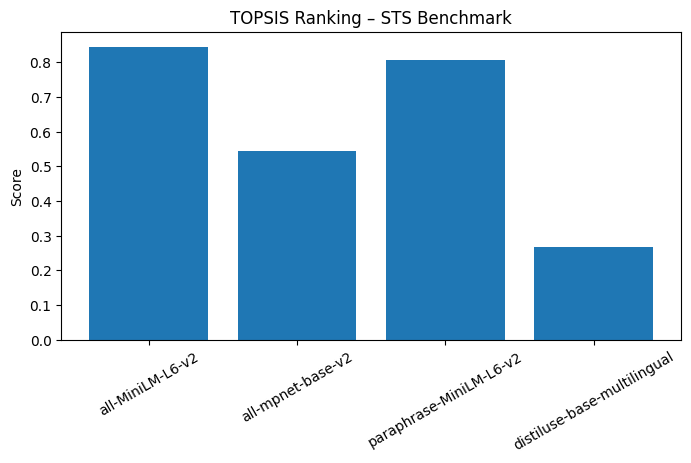

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["TOPSIS Score"])
plt.title("TOPSIS Ranking – STS Benchmark")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.show()
